In [2]:
# google drive에 있는 데이터를 사용하기 위해 접근

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 라이브러리 import
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import imageio  # 이미지 파일을 읽기 위한 라이브러리


분류 대상 이미지 : 


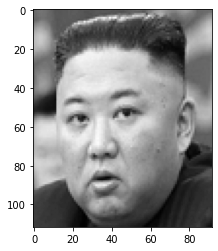

분류 대상 라벨 : 1 == 김정은


In [19]:
# 분류 대상 이미지 확인(test set에 사용되는 김정은 이미지)
im = imageio.imread('./drive/MyDrive/숨고/이인균님/data/1_10.png')
print("분류 대상 이미지 : ")
plt.imshow(im, cmap='gray') # 이미지 출력
plt.show()
print("분류 대상 라벨 : 1 == 김정은")

In [6]:
# 모든 이미지 처리 
x_train = [] # 학습 이미지 담을 변수
y_train = [] # 학습 이미지에 해당하는 라벨
x_test = []  # 테스트 이미지 담을 변수
y_test = []  # 테스트 이미지에 해당하는 라벨

for i in range(40):                                                     # 총 40명의 사람
    for j in range(10):                                                 # 한 사람 당 10장
        temp_img = imageio.imread('./drive/MyDrive/숨고/이인균님/data/{}_{}.png'.format(i+1, j+1))  # 사진 한장 불러오기
        if j<8: # 한 사람당 8장은 학습 이미지로 사용
            x_train.append(temp_img)   # 사진 담기
            y_train.append(i)        # 해당 사진의 라벨 달기
        else : # 한 사람당 2장은 테스트 이미지로 사용
            x_test.append(temp_img)    # 사진 담기
            y_test.append(i)         # 해당 사진 라벨 담기

            
# 모두 배열로 변경
x_train = np.array(x_train)
y_train = np.array(y_train).reshape(-1,1)
x_test = np.array(x_test)
y_test = np.array(y_test).reshape(-1,1)


In [7]:
# 라벨 데이터 One-Hot 으로 변경 
# 1 --> (1,0,0,0 ...)   2 --> (0,1,0,0,0 ...) 3 -> (0,0,1,0,0 ...) 좌측과 같이 변경해 주는 부분
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train).toarray()

real_label=y_test # real_label에 One-Hot 전 라벨을 담아 놓습니다. 차후에 예측값과 비교해 보기 위함
enc.fit(y_test)
y_test = enc.transform(y_test).toarray()

# 데이터 처리 후 최종 형태 확인하기
print("학습 이미지 파일 형태 : ", x_train.shape)   # 320장 * 112 * 92
print("학습 라벨 형태 : ", y_train.shape)          # 320장 * 40(One-Hot)
print("테스트 이미지 파일 형태 : ", x_test.shape)  # 80장 * 112 * 92
print("테스트 라벨 형태 : ", y_test.shape)         # 80장 * 40(One-Hot)

x_train = (x_train/255).reshape(320,112,92,1) # 형태 변환 (흑백사진은 뒤에 1을 붙여줘야함, 칼라는 3)
x_test = (x_test/255).reshape(80,112,92,1)    # 형태 변환 (흑백사진은 뒤에 1을 붙여줘야함, 칼라는 3)


학습 이미지 파일 형태 :  (320, 112, 92)
학습 라벨 형태 :  (320, 40)
테스트 이미지 파일 형태 :  (80, 112, 92)
테스트 라벨 형태 :  (80, 40)


In [8]:
# CNN (Convolutional Neural Networks) 모델 구현하기
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# tf.set_random_seed(1)
tf.random.set_seed(1)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', input_shape=(112,92,1))) 
# 16개 filter 사용, 3*3 크기 필터, 활성화 함수는 relu 사용, input 형태는 112,92,1 (세로,가로,흑백)
model.add(BatchNormalization())
# 과적합 방지 배치 노멀 처리

model.add(Conv2D(32, (3, 3), activation='relu'))
# 32개 filter 사용, 3*3 크기 필터, 활성화 함수는 relu
model.add(BatchNormalization())
# 과적합 방지 배치 노멀 처리

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 맥스풀링 사용, 크기는 2*2, padding 처리

model.add(Conv2D(32, (3, 3), activation='relu'))
# 32개 filter 사용, 3*3 크기 필터, 활설화 함수는 relu
model.add(BatchNormalization())
# 과적합 방지 배치 노멀 처리

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 맥스 풀링 사용, 크기는 2*2, padding 처리

# 위와 동일
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
# 추출되는 특징값을 펼치기

model.add(Dense(320, activation='relu', kernel_initializer='he_normal'))
# 분류를 위한 DENSE레이어와 연결, 사용한 뉴런은 320개, 활성화 함수는 relu
model.add(BatchNormalization())
# 과적합 방지 배치노멀 처리

model.add(Dense(40, activation='softmax'))
# 총 40명의 사람을 분류하기 위해 출력층은 40


model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
# 학습 방법은 adam 을 사용

model.summary() # 구현한 모델 형태 확인


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 90, 16)       160       
                                                                 
 batch_normalization (BatchN  (None, 110, 90, 16)      64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 88, 32)       4640      
                                                                 
 batch_normalization_1 (Batc  (None, 108, 88, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 44, 32)       0         
 )                                                               
                                                        

In [14]:
# 모델 학습
model.fit(x_train, y_train,
          batch_size=8, 
          epochs=15, 
          verbose=1,
          shuffle=True, 
          validation_data=[x_test,y_test])

Epoch 1/15
40/40 [==============================] - 9s 232ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 9.6140e-04 - val_accuracy: 1.0000
Epoch 2/15
40/40 [==============================] - 9s 234ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.5022e-04 - val_accuracy: 1.0000
Epoch 3/15
40/40 [==============================] - 10s 239ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 7.0183e-04 - val_accuracy: 1.0000
Epoch 4/15
40/40 [==============================] - 9s 233ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 6.4795e-04 - val_accuracy: 1.0000
Epoch 5/15
40/40 [==============================] - 10s 241ms/step - loss: 9.9041e-04 - accuracy: 1.0000 - val_loss: 5.8249e-04 - val_accuracy: 1.0000
Epoch 6/15
40/40 [==============================] - 9s 232ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/15
40/40 [==============================] - 9s 236ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.9891e-04

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


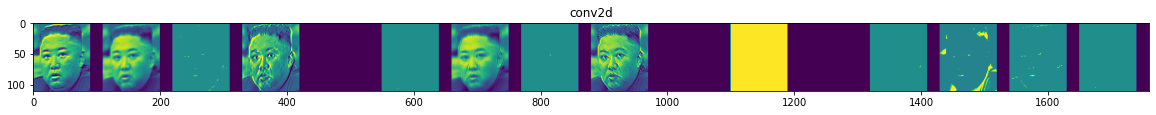

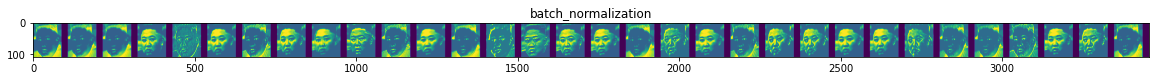

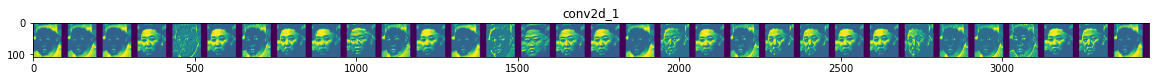

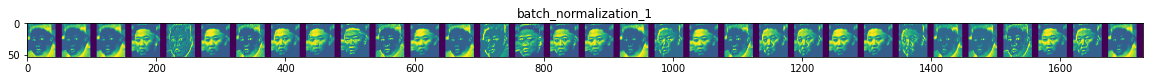

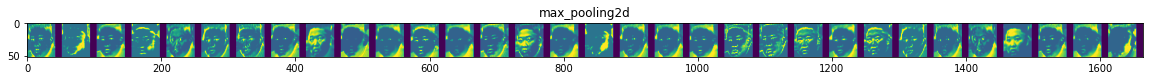

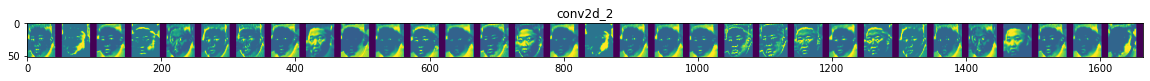

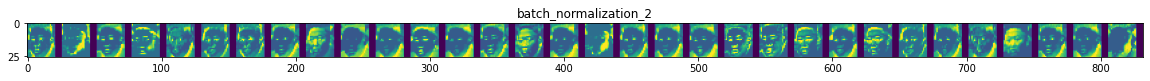

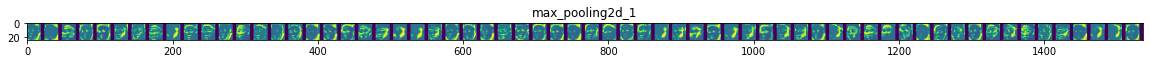

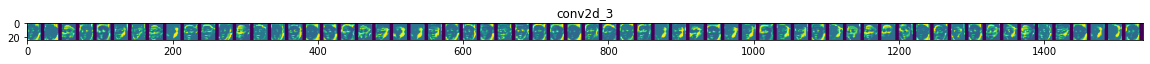

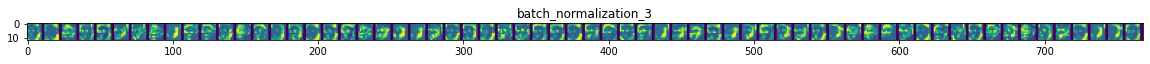

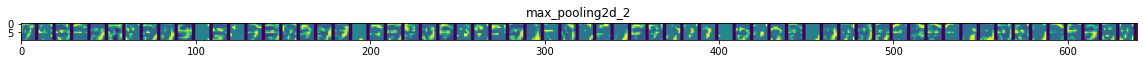

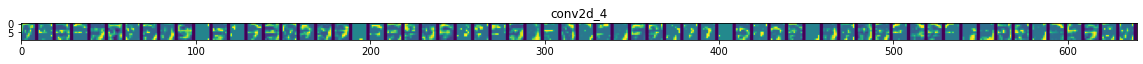

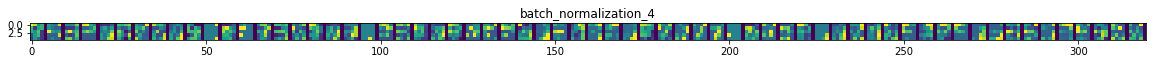

In [15]:
## Feature map 확인

img_path='./drive/MyDrive/숨고/이인균님/data/1_10.png'

# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

#Load the input image
img = load_img(img_path, target_size=(112, 93))
x = imageio.imread(img_path)                           
x = (x/255).reshape((1,) + x.shape)

# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')

        # Tile each filter into a horizontal grid
        try : 
            display_grid[:, i * size : (i + 1) * size - 20] = x
        except:
            try:
                display_grid[:, i * size : (i + 1) * size - 10] = x
            except:
                try : 
                    display_grid[:, i * size : (i + 1) * size - 5] = x
                except:
                    try : 
                        display_grid[:, i * size : (i + 1) * size - 2] = x
                    except:
                        display_grid[:, i * size : (i + 1) * size - 1] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [30]:
im.reshape((-1,112,92,1))

Array([[[[ 88],
         [ 91],
         [ 96],
         ...,
         [ 95],
         [ 93],
         [ 96]],

        [[ 88],
         [ 92],
         [ 95],
         ...,
         [ 92],
         [ 96],
         [ 98]],

        [[ 89],
         [ 90],
         [ 93],
         ...,
         [100],
         [109],
         [111]],

        ...,

        [[ 53],
         [ 50],
         [ 50],
         ...,
         [ 36],
         [ 31],
         [ 23]],

        [[ 54],
         [ 51],
         [ 50],
         ...,
         [ 27],
         [ 23],
         [ 16]],

        [[ 52],
         [ 53],
         [ 52],
         ...,
         [ 21],
         [ 14],
         [ 12]]]], dtype=uint8)

Test accuracy: 0.9624999761581421
분류 대상 이미지 : 


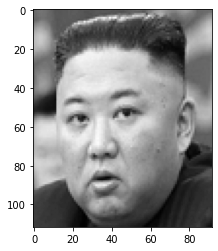

예측 라벨 : 1 == 김정은


In [33]:

# TEST 데이터로 결과 확인
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1]) # TEST 데이터에 대한 정확도

# 분류 대상 이미지 확인(test set에 사용되는 김정은 이미지)
im = imageio.imread('./drive/MyDrive/숨고/이인균님/data/1_10.png')
print("분류 대상 이미지 : ")
plt.imshow(im, cmap='gray') # 이미지 출력
plt.show()

pred = model.predict(im.reshape((1,112,92,1))/255)
pred = pred.argmax(axis=-1)
pred = pred+1
if pred == 1:
    print("예측 라벨 : 1 == 김정은")
